# Movie reviews - Canvas Discussion 3 
### Heew Kim | 2 Nov 2020

Experiment on the C parameter of the SVM model. 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

## MODIFIED feature building and extraction functions 

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data_modified(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix; added uni- & bigrams; deleted stopwords
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 16, ngram_range = (1,2), alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

## MODIFIED training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do):
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data_modified(fn='/Users/heewoong.kim/Documents/GitHub/ml/ProjectDataset/moviereviews_train.tsv', my_random_seed=99)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 65536)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9
5

## Fit (and tune) the Support-Vector Machine (SVM) linear model

In [13]:
from sklearn.svm import LinearSVC 

#set alphas and arrays
Cs = [1e-10, 2e-6, 4e-6, 6e-6, 8e-6, 1e-5, 2.5e-5, 5e-5, 1e-4, 1]
svcm={}
svcm_train={}
svcm_test={}

#loop for SVM model fitting/tuning for c parameters
for i in range(10):
    svcm[i] = LinearSVC(loss='hinge', C=Cs[i])
    svcm[i].fit(X_train, y_train)
    #train set performance compute
    svcm_train[i] = BinaryClassificationPerformance(svcm[i].predict(X_train), y_train, ('tr'+str(Cs[i])))
    svcm_train[i].compute_measures()
    #test set performance
    svcm_test[i] = BinaryClassificationPerformance(svcm[i].predict(X_test), y_test, ('ts'+str(Cs[i])))
    svcm_test[i].compute_measures()


In [14]:
#print performance measures 

for i in range(10):
    print(svcm_train[i].performance_measures)
    print(svcm_test[i].performance_measures)
    print('* * * * *')



{'Pos': 9988, 'Neg': 10012, 'TP': 8969, 'TN': 9620, 'FP': 392, 'FN': 1019, 'Accuracy': 0.92945, 'Precision': 0.9581241320371755, 'Recall': 0.8979775730877052, 'desc': 'tr1e-10'}
{'Pos': 2512, 'Neg': 2488, 'TP': 2038, 'TN': 2243, 'FP': 245, 'FN': 474, 'Accuracy': 0.8562, 'Precision': 0.8926850635129215, 'Recall': 0.8113057324840764, 'desc': 'ts1e-10'}
* * * * *
{'Pos': 9988, 'Neg': 10012, 'TP': 9419, 'TN': 9378, 'FP': 634, 'FN': 569, 'Accuracy': 0.93985, 'Precision': 0.9369342484830399, 'Recall': 0.9430316379655587, 'desc': 'tr2e-06'}
{'Pos': 2512, 'Neg': 2488, 'TP': 2197, 'TN': 2127, 'FP': 361, 'FN': 315, 'Accuracy': 0.8648, 'Precision': 0.8588741204065676, 'Recall': 0.8746019108280255, 'desc': 'ts2e-06'}
* * * * *
{'Pos': 9988, 'Neg': 10012, 'TP': 9679, 'TN': 9613, 'FP': 399, 'FN': 309, 'Accuracy': 0.9646, 'Precision': 0.9604088112720778, 'Recall': 0.9690628754505406, 'desc': 'tr4e-06'}
{'Pos': 2512, 'Neg': 2488, 'TP': 2246, 'TN': 2134, 'FP': 354, 'FN': 266, 'Accuracy': 0.876, 'Precis

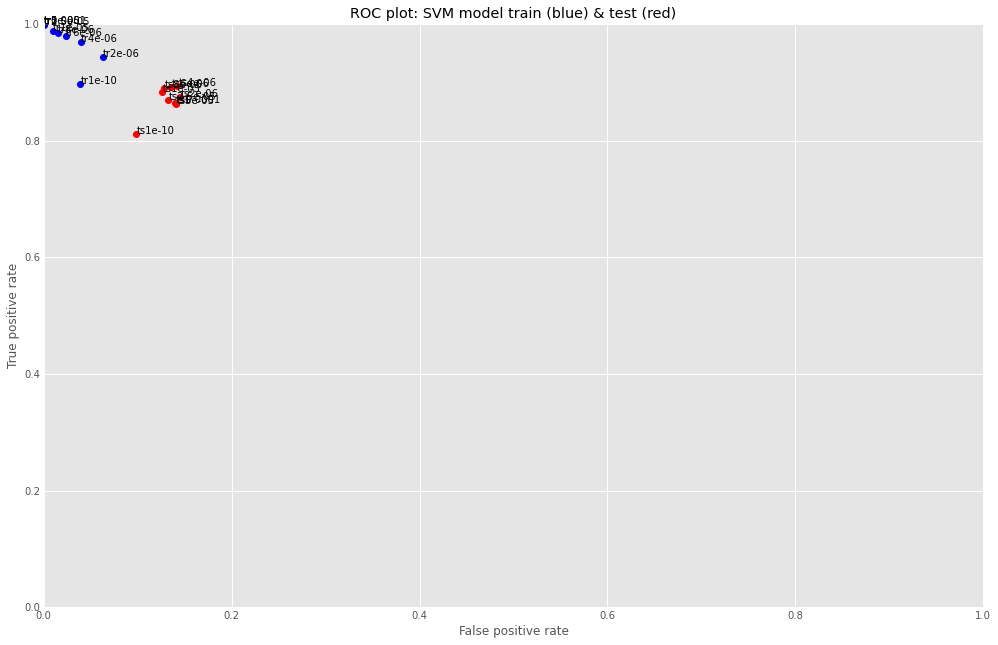

In [15]:
#ROC plot original range

plt.style.use('fivethirtyeight')
plt.style.use('ggplot')

plt.figure(figsize=(15,10))
for i in range(10):
    plt.plot(svcm_train[i].performance_measures['FP'] / svcm_train[i].performance_measures['Neg'],
             svcm_train[i].performance_measures['TP'] / svcm_train[i].performance_measures['Pos'], 'bo')
    plt.text(svcm_train[i].performance_measures['FP'] / svcm_train[i].performance_measures['Neg'],
             svcm_train[i].performance_measures['TP'] / svcm_train[i].performance_measures['Pos'], svcm_train[i].desc)
    plt.plot(svcm_test[i].performance_measures['FP'] / svcm_test[i].performance_measures['Neg'],
             svcm_test[i].performance_measures['TP'] / svcm_test[i].performance_measures['Pos'], 'ro')
    plt.text(svcm_test[i].performance_measures['FP'] / svcm_test[i].performance_measures['Neg']+0.001,
             svcm_test[i].performance_measures['TP'] / svcm_test[i].performance_measures['Pos'], svcm_test[i].desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: SVM model train (blue) & test (red)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

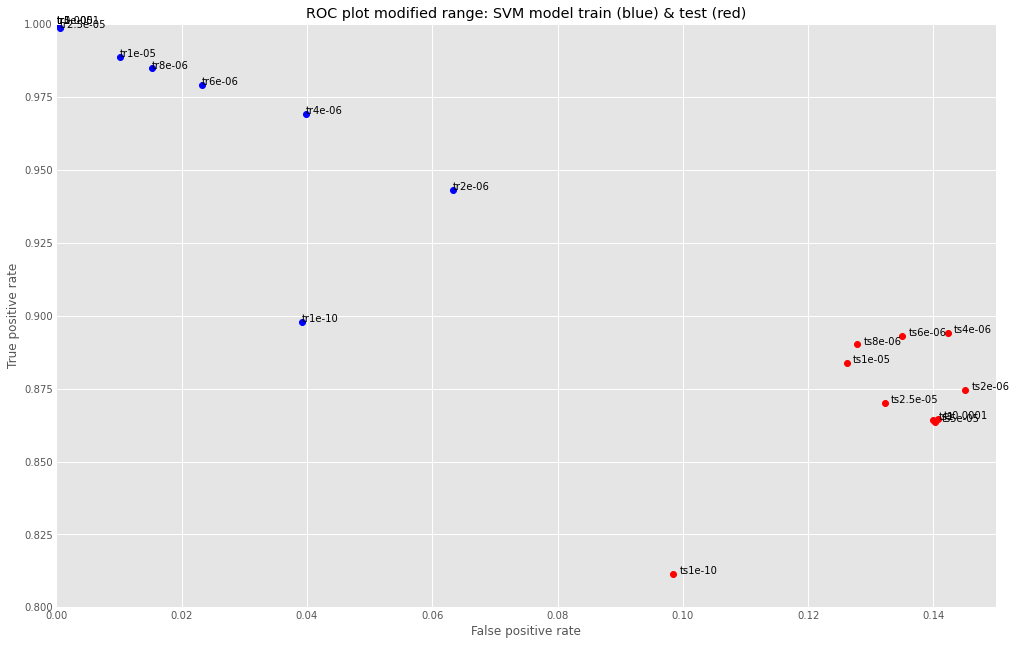

In [17]:
#ROC plot modified range

plt.style.use('fivethirtyeight')
plt.style.use('ggplot')

plt.figure(figsize=(15,10))
for i in range(10):
    plt.plot(svcm_train[i].performance_measures['FP'] / svcm_train[i].performance_measures['Neg'],
             svcm_train[i].performance_measures['TP'] / svcm_train[i].performance_measures['Pos'], 'bo')
    plt.text(svcm_train[i].performance_measures['FP'] / svcm_train[i].performance_measures['Neg'],
             svcm_train[i].performance_measures['TP'] / svcm_train[i].performance_measures['Pos'], svcm_train[i].desc)
    plt.plot(svcm_test[i].performance_measures['FP'] / svcm_test[i].performance_measures['Neg'],
             svcm_test[i].performance_measures['TP'] / svcm_test[i].performance_measures['Pos'], 'ro')
    plt.text(svcm_test[i].performance_measures['FP'] / svcm_test[i].performance_measures['Neg']+0.001,
             svcm_test[i].performance_measures['TP'] / svcm_test[i].performance_measures['Pos'], svcm_test[i].desc)
plt.axis([0, 0.15, 0.8, 1])
plt.title('ROC plot modified range: SVM model train (blue) & test (red)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()


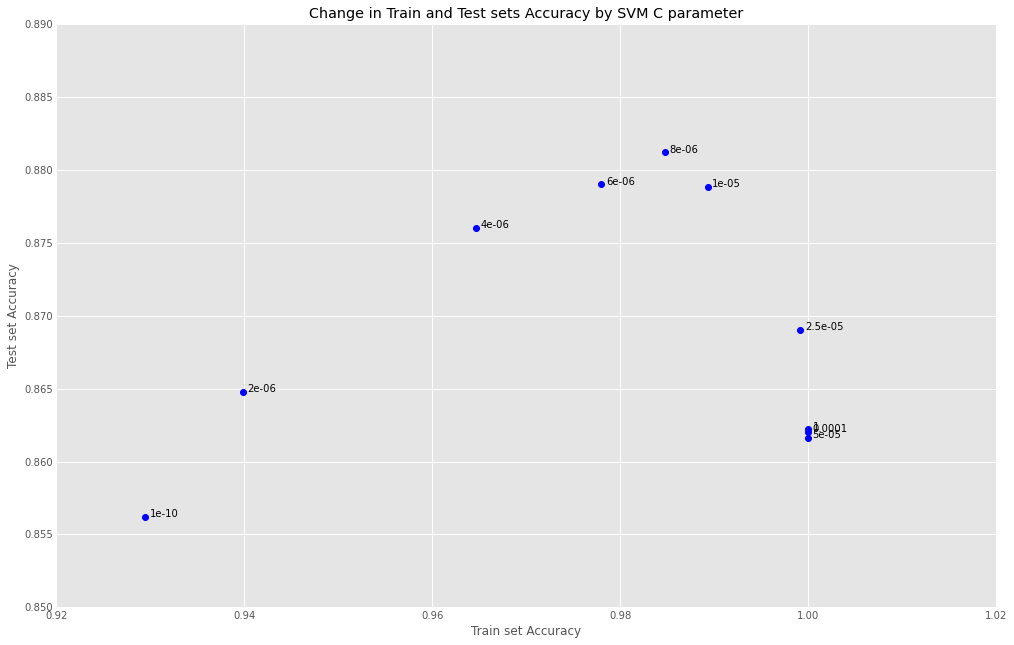

In [26]:
# Train and Test Accuracy Plot

plt.figure(figsize=(15,10))

for i in range(10):
    plt.plot(svcm_train[i].performance_measures['Accuracy'], svcm_test[i].performance_measures['Accuracy'], 'bo')
    plt.text(svcm_train[i].performance_measures['Accuracy']+5e-4, svcm_test[i].performance_measures['Accuracy'], Cs[i])
    
plt.axis([0.92, 1.02, 0.85, .89])
plt.title('Change in Train and Test sets Accuracy by SVM C parameter')
plt.xlabel('Train set Accuracy')
plt.ylabel('Test set Accuracy')
plt.show()

In [27]:
# Accuracy Table View 

svcm_train_df = []
svcm_test_df = []

for i in range(10):
    svcm_train_df.append(svcm_train[i].performance_measures['Accuracy'])
    svcm_test_df.append(svcm_test[i].performance_measures['Accuracy'])

df = pd.concat([pd.DataFrame(Cs), pd.DataFrame(svcm_train_df), pd.DataFrame(svcm_test_df)], axis=1)
df.columns = ['C', 'train_accuracy', 'test_accuracy']

df


,C,train_accuracy,test_accuracy
0,1.000000e-10,0.92945,0.8562
1,2.000000e-06,0.93985,0.8648
2,4.000000e-06,0.96460,0.8760
3,6.000000e-06,0.97800,0.8790
4,8.000000e-06,0.98475,0.8812
5,1.000000e-05,0.98930,0.8788
6,2.500000e-05,0.99915,0.8690
7,5.000000e-05,0.99995,0.8616
8,1.000000e-04,1.00000,0.8620
9,1.000000e+00,1.00000,0.8622


---

# Summary of work and performance  

I used sklearn.svm.LinearSVC to carry out the linear sector vector machine model with the modified features for the movie review dataset. The C parameter used at the end were '1e-10, 2e-6, 4e-6, 6e-6, 8e-6, 1e-5, 2.5e-5, 5e-5, 1e-4, 1' after testing a few different compositions. C parameters above 5e-5 or bigger than 1 had no difference in the performance of both the train and test set predictions. There was only notable difference in the model performances for very small C values below 2.5e-5 or smaller. 

**Train set performance by C values**: The performance is between 1 to 0.99 for C values of 1e-5 to 1. The performance starts to decrease to below 0.98 from 8e-6 and decrease more notably from 4e-6 and below moving the accurancy to 0.93-0.96.  

**Test set performance by C values**: The performance in the test set slightly increases from .86 to around 0.88 when moving the C values from 1 to 8e-6. However, if you decrease the C further beyond this value, the accuracy once again starts to decrease back to 0.86 or below. 

**Optimal C for performance**: All in all, the model performance only increase for very small C parameters indicating that larger margin hyperplans seem to make difference in the perdictions. However, if you continue to decrease the C we see that both the train and test set prediction performance starts to suffer. It seems that around 8e-6 seem to be the optimum value to have the strongest performance in both the train and test set. 